In [99]:
import re, aiohttp, aiofiles
from PIL import (Image, ImageDraw, ImageEnhance, ImageFilter, ImageFont)
from youtubesearchpython.__future__ import VideosSearch

In [100]:
def changeImageSize(maxWidth, maxHeight, image):
    widthRatio = maxWidth / image.size[0]
    heightRatio = maxHeight / image.size[1]
    newWidth = int(widthRatio * image.size[0])
    newHeight = int(heightRatio * image.size[1])
    newImage = image.resize((newWidth, newHeight))
    return newImage

def clear(text):
    list = text.split(" ")
    title = ""
    for i in list:
        if len(title) + len(i) < 60:
            title += " " + i
    return title.strip()

def create_smooth_rainbow_gradient(width, height):
    """
    Create a smooth rainbow gradient image with given width and height.
    """
    gradient = Image.new('RGBA', (width, height))
    draw = ImageDraw.Draw(gradient)

    # Define rainbow colors
    rainbow_colors = [
        (255, 0, 0),     # Red
        (255, 127, 0),   # Orange
        (255, 255, 0),   # Yellow
        (0, 255, 0),     # Green
        (0, 0, 255),     # Blue
        (75, 0, 130),    # Indigo
        (148, 0, 211)    # Violet
    ]
    
    num_colors = len(rainbow_colors)
    
    for y in range(height):
        # Calculate the ratio of the current position
        ratio = y / height
        # Determine the positions in the rainbow_colors list
        i = int(ratio * (num_colors - 1))
        # Calculate the fractional part
        f = ratio * (num_colors - 1) - i

        # Get the start and end colors for the interpolation
        start_color = rainbow_colors[i]
        end_color = rainbow_colors[i + 1]

        # Interpolate between the two colors
        r = int(start_color[0] + f * (end_color[0] - start_color[0]))
        g = int(start_color[1] + f * (end_color[1] - start_color[1]))
        b = int(start_color[2] + f * (end_color[2] - start_color[2]))

        # Draw the line with the interpolated color
        draw.line([(0, y), (width, y)], fill=(r, g, b))

    return gradient

async def get_thumb(videoid):
    # if os.path.isfile(f"cache/{videoid}.png"):
    #     print(f"Thumbnail {videoid}.png already exists")
    #     return f"cache/{videoid}.png"

    url = f"https://www.youtube.com/watch?v={videoid}"
    try:
        results = VideosSearch(url, limit=1)
        for result in (await results.next())["result"]:
            try:
                title = result["title"]
                title = re.sub("\W+", " ", title)
                title = title.title()
            except:
                title = "Unsupported Title"
            try:
                duration = result["duration"]
            except:
                duration = "Unknown Mins"
            thumbnail = result["thumbnails"][0]["url"].split("?")[0]
            try:
                views = result["viewCount"]["short"]
            except:
                views = "Unknown Views"
            try:
                channel = result["channel"]["name"]
            except:
                channel = "Unknown Channel"

        async with aiohttp.ClientSession() as session:
            async with session.get(thumbnail) as resp:
                if resp.status == 200:
                    f = await aiofiles.open(f"cache/thumb{videoid}.png", mode="wb")
                    await f.write(await resp.read())
                    await f.close()

        youtube = Image.open(f"cache/thumb{videoid}.png")
        image1 = changeImageSize(1280, 720, youtube)
        image2 = image1.convert("RGBA")
        # background = image2.filter(filter=ImageFilter.GaussianBlur(2.5))
        background = image2.filter(filter=ImageFilter.BoxBlur(0.5))
        enhancer = ImageEnhance.Brightness(background)
        background = enhancer.enhance(0.5)

        width, height = background.size
        # Create the rainbow gradient image
        gradient = create_smooth_rainbow_gradient(width, height)
        # Apply 50% opacity to the gradient
        gradient = gradient.convert('RGBA')
        gradient.putalpha(25)  # 10% opacity
        # Overlay the gradient onto the original image
        background = Image.alpha_composite(background, gradient)

        draw = ImageDraw.Draw(background)
        font1 = ImageFont.truetype("VenomX/assets/font.ttf", 30) # Garet Regular
        font2 = ImageFont.truetype("VenomX/assets/font2.ttf", 30) # Garet Bold
        font3 = ImageFont.truetype("VenomX/assets/font3.ttf", 60) # Sweet Diary

        # Draw the shadow
        shadow_position = (900 + 1, 30 + 1)
        draw.text(shadow_position, '@SerikatWibuMaifam', fill='black', font=font3)
        shadow_position = (55 + 1, 560 + 1)
        draw.text(shadow_position, f"{channel.title()} | {views[:23].title()}", fill='black', font=font1)
        shadow_position = (57 + 1, 600 + 1)
        draw.text(shadow_position, clear(title), fill='black', font=font2)

        # Draw the actual text
        draw.text((900, 30), '@SerikatWibuMaifam', fill='white', font=font3)
        draw.text((55, 560), f"{channel.title()} | {views[:23].title()}", fill='white', font=font1)
        draw.text((57, 600), clear(title), fill='white', font=font2)
        draw.line([(55, 660), (1220, 660)], fill='white', width=5, joint='curve')
        draw.ellipse([(918, 648), (942, 672)], outline='white', fill='white', width=15)
        # draw.text((55, 665), "00:00", (255, 255, 255), font=font1)
        # draw.text((1200, 665), f"{duration[:23]}", (255, 255, 255), font=font1)

        background.save(f"cache/{videoid}.png")
        return f"cache/{videoid}.png"
    except Exception as e:
        print(e)
        return None

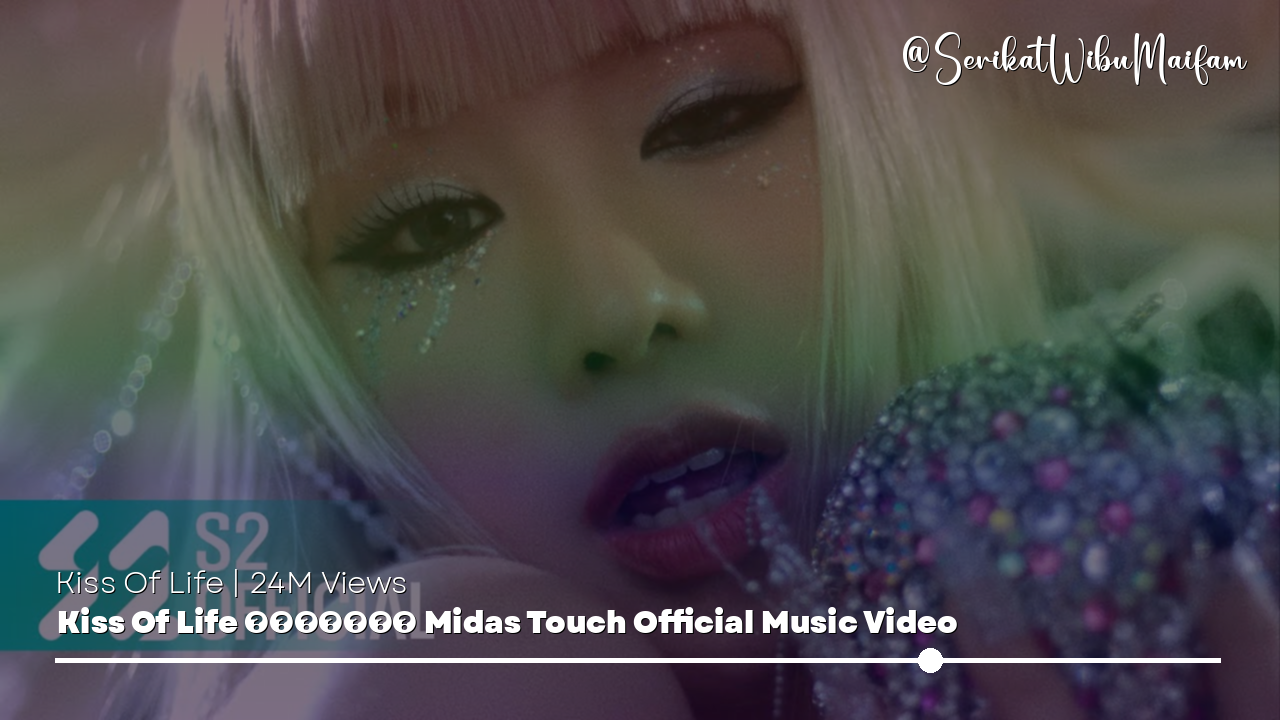

In [101]:
from IPython.display import Image as IPImage
yt_id = "oKVYm8mIUdo"
image_path = await get_thumb(yt_id)
IPImage(filename=image_path)